<H1> Classification d'images avec des CNN</H1>

Dans ce notebook nous nous intéressons à la classification d'images. Nous avons vu dans le notebook classification d'images que les approches traditionnelles n'étaient pas efficace et nous avons introduit les modèles de type convolution. Dans ce notebook nous nous focalisons sur ces derniers.  

Les données utilisées sont toujours Fashion MNIST.  

**Remarque :** Attention l'objectif de ce notebook n'est pas de chercher le meilleur classifieur ou les meilleures couches à utiliser pour classer le mieux possible les données. Fashion MNIST est un peu plus difficile à classer que MNIST (images de nombres de 0 à 9 écrits à la main) mais on peut facilement obtenir une excellente accuracy sans sur-apprentissage. L'objectif est plutôt de se focaliser sur les CNN et de mieux les comprendre. De nombreuses améliorations (dropout, learning rate, batch normalisation, pénalisation (L2) au niveau de la cost function peuvent bien sûr être utilisés pour améliorer la qualité du modèle. 


## Installation



Avant de commencer, il est nécessaire de déjà posséder dans son environnement toutes les librairies utiles. Dans la seconde cellule nous importons toutes les librairies qui seront utiles à ce notebook. Il se peut que, lorsque vous lanciez l'éxecution de cette cellule, une soit absente. Dans ce cas il est nécessaire de l'installer. Pour cela dans la cellule suivante utiliser la commande :  

*! pip install nom_librairie*  

**Attention :** il est fortement conseillé lorsque l'une des librairies doit être installer de relancer le kernel de votre notebook.

**Remarque :** même si toutes les librairies sont importées dès le début, les librairies utiles pour des fonctions présentées au cours de ce notebook sont ré-importées de manière à indiquer d'où elles viennent et ainsi faciliter la réutilisation de la fonction dans un autre projet.



In [ ]:
# utiliser cette cellule pour installer les librairies manquantes
# pour cela il suffit de taper dans cette cellule : !pip install nom_librairie_manquante
# d'exécuter la cellule et de relancer la cellule suivante pour voir si tout se passe bien
# recommencer tant que toutes les librairies ne sont pas installées ...

In [3]:
# Importation des différentes librairies utiles pour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
from scipy.stats import randint
import numpy as np
import string
import time
import base64
import re
import sys
import copy


# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score

# TensorFlow et keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tqdm import tqdm
from keras.models import load_model
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image


In [ ]:
def plot_curves_confusion (history,confusion_matrix,class_names):
  plt.figure(1,figsize=(16,6))
  plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)

  # division de la fenêtre graphique en 1 ligne, 3 colonnes,
  # graphique en position 1 - loss fonction

  plt.subplot(1,3,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Training loss', 'Validation loss'], loc='upper left')
  # graphique en position 2 - accuracy
  plt.subplot(1,3,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
  
  # matrice de correlation
  plt.subplot(1,3,3)
  sns.heatmap(conf,annot=True,fmt="d",cmap='Blues',xticklabels=class_names, yticklabels=class_names)# label=class_names)
  # labels, title and ticks
  plt.xlabel('Predicted', fontsize=12)
  #plt.set_label_position('top') 
  #plt.set_ticklabels(class_names, fontsize = 8)
  #plt.tick_top()
  plt.title("Correlation matrix")
  plt.ylabel('True', fontsize=12)
  #plt.set_ticklabels(class_names, fontsize = 8)
  plt.show()
  
def plot_curves(histories):
    plt.figure(1,figsize=(16,6))
    plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1,
                          top = 0.9, wspace = 0.25, hspace = 0)
    for i in range(len(histories)):
    	# plot loss
    	plt.subplot(121)
    	plt.title('Cross Entropy Loss')
    	plt.plot(histories[i].history['loss'], color='blue', label='train')
    	plt.plot(histories[i].history['val_loss'], color='red', label='test')  
    	plt.ylabel('loss')
    	plt.xlabel('epoch')
    	plt.legend(['Training loss', 'Validation loss'], loc='upper left')
    	# plot accuracy
    	plt.subplot(122)
    	plt.title('Classification Accuracy')
    	plt.ylabel('accuracy')
    	plt.xlabel('epoch')
    	plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    	plt.plot(histories[i].history['val_accuracy'], color='red', 
                 label='test')
    	plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
    plt.show()

Pour pouvoir sauvegarder sur votre répertoire Google Drive, il est nécessaire de fournir une autorisation. Pour cela il suffit d'éxecuter la ligne suivante et de saisir le code donné par Google.

In [29]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Corriger éventuellement la ligne ci-dessous pour mettre le chemin vers un répertoire spécifique dans votre répertoire Google Drive : 

In [30]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Colab Notebooks/ML_FDS


'/content/gdrive/My Drive/Colab Notebooks/ML_FDS'

# Le jeu de données Fashion MNINST

Comme nous l'avons fait dans le notebook sur la classification d'images, nous allons continuer à utiliserr le jeu de données Fashion MNIST. 

Lecture du jeu de données : 

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


Quelques informations sur le jeu de données montrent qu'il y a bien 60000 images pour l'entraînement et que chaque image est une matrice de 28x28.

Nombre d'exemples du jeu d'apprentissage :  60000
Format du jeu d'apprentissage :  (60000, 28, 28)
Format des labels pour le jeu d'apprentissage' :  (60000,) 

Nombre d'exemples du jeu de test :  10000
Nombre de features du jeu de test :  28
Format des labels pour le jeu de test :  (10000,) 

Exemple de labels 9 

Distribution des labels dans le jeu d'apprentissage


Text(0.5, 1.0, "Nombre d'éléments par classe")

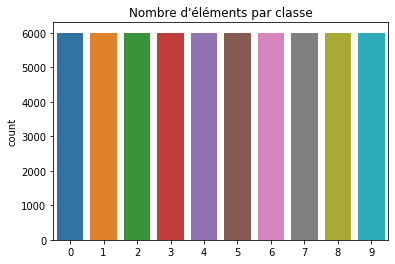

In [ ]:
print("Nombre d'exemples du jeu d'apprentissage : ", X_train.shape[0])
print ("Format du jeu d'apprentissage : ", X_train.shape)
print("Format des labels pour le jeu d'apprentissage' : ", y_train.shape, '\n')
print("Nombre d'exemples du jeu de test : ", X_test.shape[0])
print ("Nombre de features du jeu de test : ", X_test.shape[1])
print("Format des labels pour le jeu de test : ", y_test.shape, '\n')
print ("Exemple de labels",y_train[0], '\n')
print ("Distribution des labels dans le jeu d'apprentissage")
sns.countplot(np.array(y_train))
plt.title("Nombre d'éléments par classe")

Comme les labels sont encodés de 0 à 9, nous créons une classe pour labeliser les images. 

In [ ]:
print ("Création d'une classe pour pouvoir labéliser les images lors de l'affichage")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Création d'une classe pour pouvoir labéliser les images lors de l'affichage


Affichage de plusieurs images : 

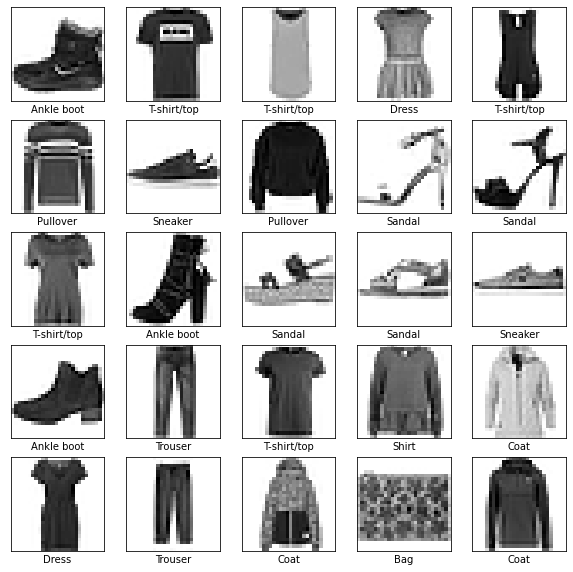

In [ ]:
#Visualisation d'images
plt.figure(figsize=(10,10))
columns = 25
for i in range(columns):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i],cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

Nous ne revenons pas ici sur les visualisations de données et l'utilisation de PCA, UMPA ou TSNE. Il suffit de se reporter au notebook Classification d'images.

### Pré-traitement des données

Inspection d'une image en affichant les valeurs des pixels :

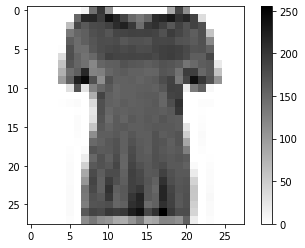

In [ ]:
numimage=10
plt.figure()
plt.imshow(X_train[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
#plt.xlabel(class_names[train_labels[numimage]])
plt.show()

**Transformation des donnees**  
Nous pouvons constater que les valeurs de gris des pixels varient de 0 à 255 (droite de l'image). Il faut donc les "normaliser" entre 0 et 1. Ne pas oublier d'effectuer le même traitement pour le jeu de test.

In [ ]:
# Sauvegarde des données avant transformation
X_train_original=copy.deepcopy(X_train)
X_test_original=copy.deepcopy(X_test)

train_images = X_train / 255.0
test_images = X_test / 255.0

Affichage pour vérifier que la transformation a bien été réalisée.

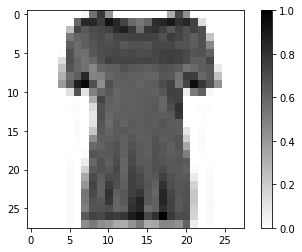

In [ ]:
numimage=10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
#plt.xlabel(class_names[train_labels[numimage]])
plt.show()

###Un modèle Baseline

Dans cette section nous réalisons un modèle "baseline". Il permet de proposer une base à partir de laquelle nous pouvons améliorer les résultats. 

Dans un premier temps nous proposons quelques fonctions :

La première fonction permet de charger le jeu de données et de forcer à n'utiliser qu'un seul canal (noir et blanc). Cela se fait par l'intermédiaire du reshape. 

In [ ]:

def load_dataset():
	# Chargement des données
	(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
	# ne considérer qu'un seul canal
	X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
	X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
	# one hot encoding
	y_train = to_categorical(y_train)
	y_test = to_categorical(y_test)
	return X_train, y_train, X_test, y_test


La seconde fonction nettoie les données : conversion en float et normalisation pour éviter les trop grandes valeurs.
 

In [ ]:
def clean_data(train, test):
	# convertion d'entier en float
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalisation entre 0 et 1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	return train_norm, test_norm


Pour évaluer le modèle nous utilisons un K-fold. Pour que les expérimentations ne durent pas trop longtemps le nombre de folds par défaut est fixé à 5 et le nombre d'epochs à 10. 

In [ ]:
# Evaluation avec un k-fold
def evaluate_model(model, dataX, dataY, n_folds=5, epochs=10):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # parcourir les splits du k-fold
    for train_ix, test_ix in kfold.split(dataX):
    	# selection des données
    	X_train, y_train, X_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    	# fit du modele
    	history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, 
                         validation_data=(X_test, y_test), verbose=1)
    	# evaluate du modele
    	loss, acc = model.evaluate(X_test, y_test, verbose=0)
    	print('accuracy %.3f' % (acc * 100.0))
    	scores.append(acc)
    	histories.append(history)
    return scores, histories

A présent, nous considérons le modèle. Pour le modèle baseline nous allons faire un modèle assez simple : une couche conv2D et un pooling suivi bien entendu par un flatten et une couche dense avant d'avoir une couche finale avec un softmax. La taille du filtre est de 3x3 et il y a 32 filtres :

In [ ]:
# definition du premier modèle baseline
def define_model():
    model = Sequential()
    # Convolution and pooling
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     activation='relu', input_shape=(28, 28, 1), 
                     name="Conv2D_1"))
    model.add(MaxPooling2D(pool_size=(2, 2), 
                           name="Maxpooling2D_1"))
    
		# flatten
    model.add(Flatten(name="flatten") )
    
    # Partie classification 
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

La fonction suivante permet de lancer l'ensemble des fonctions précédentes. 

In [ ]:
# fonction pour charger, transformer et évaluer le modele
# elle lance n-folds fois l'évaluation et affiche les courbes et résultats
def run_evaluation(n_folds,epochs):
	# load dataset
	X_train, y_train, X_test, y_test = load_dataset()
	# Nettoyage et normalisation
	X_train, X_test = clean_data(X_train, X_test)
	# define model
	model = define_model()
	print (model.summary())
	# evaluate model
	scores, histories = evaluate_model(model, X_train, y_train, n_folds,epochs)
	plot_curves(histories)
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))


Evaluation du modèle : 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 13, 13, 32)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



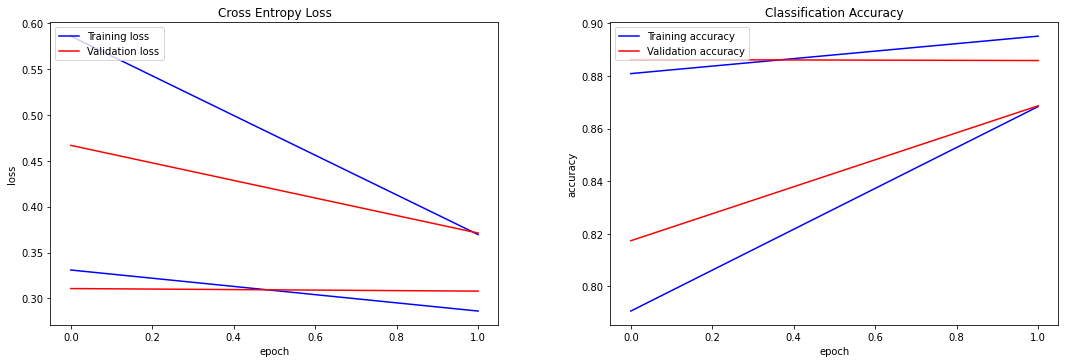

Accuracy: mean=87.723 std=0.860, n=2


In [ ]:
n_folds=2
epochs=2
run_evaluation(n_folds,epochs)

####Analyse du modèle


**Analyse des taille des couches de sorties**  

L'achitecture du réseau nous montre que pour la convolution, la sortie de la couche de convolution, *CONV2D_1*, est de la forme (26, 26, 32).  
Les images font 28x28. Le nombre de filtres est 32 (K=32) avec une taille de (3, 3) (F=5). Il n'y a pas de padding (P=0).  Par défaut le stride est de 1 (S=1).
Avec :    
W2 = (W1 - F + 2xP)/S +1  
H2 = (H1 – F + 2xP)/S +1  
D2 : K  

On a :  
W2 = (28 - 3 + 2x0)/1 +1 = 26  
H2 = (28 - 3 + 2x0)/1 +1 = 26  
D2 = 32.  

Pour la couche MaxPooling, *Maxpooling2D_1*, nous avons : (None, 13, 13, 32).
En entrée W2=26, H2=26 et D2=32. Il s'agit de la couche de sortie de la convolution. La taille du pool_size est (2,2). **Attention**, ici aucun stride n'a été donné, *strides = none*. Sous Keras si *strides = none* il est initialisé avec la valeur du pool_size.  Donc : S=2.   
W3 = (26 - 2 + 2x0)/2 +1 = 13  
H3 = (26 - 2 + 2x0)/2 +1 = 13  
D3 = 32   

Pour la couche flatten, avec (None, 5408), il s'agit simplement d'applatir la sortie précédente donc la taille vaut : W3 x H3 x D3 = 13 x 13 x 32 = 5408.  
Les tailles des deux sorties dense (*dense_6* et *dense_7*) correspondent aux nombres de neurones des couches.  


**Analyse du nombre de paramètres des couches** 
Le nombre de paramètres de la couche de convolution, *CONV2D_1*, 320. Il correspond aux différentes valeurs du filtre qui seront apprises par le modèle.   

Dans notre cas, nous avons une image de (28, 28, 1). Le 1 correspond à la valeur de canal, i.e. noir et blanc et une image est donc une matrice sans profondeur. Un canal peut être de 3 pour RGB et dans ce cas on a (28, 28, 3) et la profondeur est de 3.  
Ici un filtre est une matrice de taille (3,3). Donc les paramètres associés pour un filtre sont : 3 x 3 x *valeur_canal* paramètres. **Attention** : il ne faut pas oublier qu'il y a un paramètre en plus : le biais. Donc les paramètres associés pour un filtre avec une valeur de canal de 1 sont : 3 x 3 + 1 = 10.  
Il y a 32 filtres donc le nombres de paramètres est : 32 x 10 = 320.  

MaxPooling et Flatten n'apprennent pas de paramètres.   


Pour voir le nombre de paramètres des parties denses (partie MultiLayer Perceptron), pour chaque layer *L*, nous avons :   
*param[L]=(NombreNeurones[L] x NombreNeurones[L-1]) + NombreNeurones[L]*  

Ici pour *dense_6* le nombre de paramètres est :  540900. Le nombre de neurones de la couche précédente (Flatten) correspond à la sortie, soit : 5408.  *dense_6* possède 100 neurones donc le nombre de paramètres pour *dense_6* est :   
(100 x 5408) + 100 = 540900.  

Pour *dense_7* la valeur est de 1010. En effet, nous avons 10 neurones dans *dense_7*, *dense_6* possède 100 neurones donc le nombre de paramètres est : (10 x 100) + 10 = 1010.  

**Conclusion sur les tailles et le nombre de paramètres**  
Nous avons vu que l'un des premiers objectifs des CNN est de créer au fur et à mesure des images plus petites. Ici nous partons d'une image qui fait 28 x 28 et après la première convolution elle fait 26 x 26. On a également vu que les CNN permettaient de considérablement diminuer le nombre de paramètres par rapport à un MultiLayerPerceptron. Les chiffres du modèle le prouvent. Cela a donc forcément une conséquence forte sur les temps de calcul. 

####**Analyse des résultats de l'apprentissage**

Clairement le modèle actuel fait du sur-apprentissage : en regardant la courbe de loss nous voyons bien que la courbe sur le jeu d'apprentissage (bleue) continue à baisser alors que la courbe pour le jeu de test (rouge) diminue puis commence à s'arrêter vers l'epoch 3.   

Il existe de nombreuses méthodes pour améliorer cet apprentissage et éviter le sur apprentissage : augmenter les données, voir le learning rate, faire du dropout pour éviter qu'il ne converge trop vite, modifier la taille des batch size, etc.   
Nous pouvons aussi jouer sur le padding (est-ce que les bords des images sont importants ? ). Remarque : Keras offre deux possibilités : "*valid*" ou "*same*" "*valid*" signifie pas de remplissage, i.e. c'est la valeur par défaut. "*same*" met des zéros uniformément à gauche/droite ou haut/bas de l'entrée. Lorsque padding="same" et strides=1, la sortie a la même taille que l'entrée.  
Par exemple la couche CONV2D avec padding pourrait être la suivante :     

*model.add(Conv2D(filters=32, kernel_size=(3, 3),   
                     activation='relu', padding="same",  
                     input_shape=(28, 28, 1),   
                     name="Conv2D_1"))*


Le but de ce notebook n'est pas de rechercher le meilleur classifieur mais plutôt de montrer comment on construit un CNN et surtout de bien comprendre les conséquences des différents paramètres sur la taille et le nombre de paramètres. Aussi dans les sections suivantes nous intéressons à d'autres aspects comme l'augmentation des données, la visualisation des couches intermédiaires, etc. 



###Augmentation des données

L'objectif ici est de partir des données existantes et de générer à partir de celles-ci des transformations (zoom, décalage, floue, etc.) afin d'enrichir le jeu de données.   

Keras propose une classe ImageDataGenerator qui offre toutes ces fonctionnalités :    

    #  tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None)

Les cellules ci-dessous illustre quelques exemples :    

In [ ]:
X_train, y_train, X_test, y_test = load_dataset()
# nettoyage et normlisation des données
X_train, X_test = clean_data(X_train, X_test)

Retournement vertical ou horizontal :    

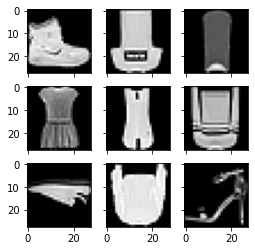

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# configuration du batch size et récupération d'un batch d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # Affichage de 3x3
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.show()
    break

Rotation :    

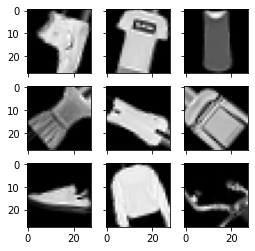

In [ ]:
datagen = ImageDataGenerator(rotation_range=80)
# configuration du batch size et récupération d'un batch d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # Affichage de 3x3
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.show()
    break

Décalage :    

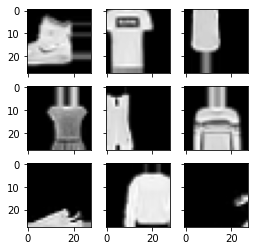

In [ ]:
shift = 0.4
datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
# configuration du batch size et récupération d'un batch d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # Affichage de 3x3
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.show()
    break

Zoom :    

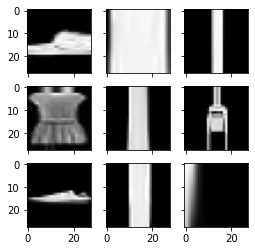

In [ ]:
datagen = ImageDataGenerator(zoom_range=1.5)
# configuration du batch size et récupération d'un batch d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # Affichage de 3x3
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.show()
    break

Zoom inverse et retournement vertical :    

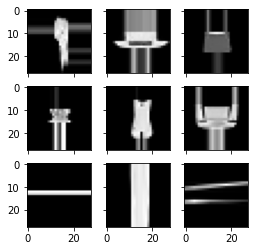

In [ ]:
datagen = ImageDataGenerator(zoom_range=-4, vertical_flip=True )
# configuration du batch size et récupération d'un batch d'images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, shuffle=False):
    # Affichage de 3x3
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(4,4))
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(X_batch[i*3+j].reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.show()
    break

**Fonctionnement de ImageDataGenerator.**   

Le principe général d'ImageDataGenerator est de préciser quelles sont les modifications à apporter aux images de base (il suffit de spécifier ce que l'on souhaite dans les paramètres comme l'indiquent les exemples précédents).   

ImageDataGenerator est utilisée par une autre méthode *flow* qui permet de remplir un batch d'images générées à partir des spécification d'ImageDataGenerator (les images d'origine ne seront pas vues par le modèle) à la volée, i.e. dans la création du batch. L'avantage est que cela permet de générer des données qui ne seront jamais vues et donc permet d'éviter le sur apprentissage. L'inconvénient est que cela ajoute un peu de temps à l'apprentissage (le temps de générer les données).   

Il est par contre possible de sauvegarder les images dans un répertoire pour les utiliser ultérieurement si l'on ne veut pas générer à la volée mais plutôt lire sur le disque. Il suffit de préciser le nom du répertoire (*save_to_dir*). L'avantage est que cela permet de vérifier les images générées.   

**Attention** vous ne contrôlez pas ce qui est généré et parfois cela met du bruit dans vos images.

**Remarque importante** *Flow* est un itérateur cela veut dire qu'il peut générer des images à l'infini !!!! 


    #  flow(
    x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None,
    save_to_dir=None, save_prefix='', save_format='png', subset=None)

L'exemple ci-dessous illustre le fait que l'on génére à l'infini. Ici on stope quand on a vu 10 images. Sans la sortie ... on continue à générer. Dans les exemples précédents cela était fait via le *break*. *Remarque* ici le batch size a été mis à 1, on a 1 image par batch_size.

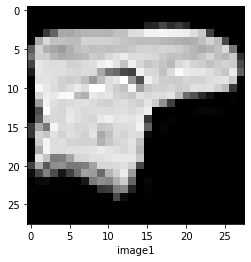

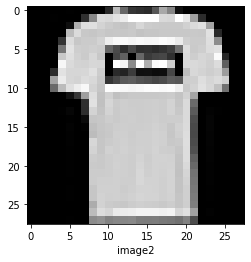

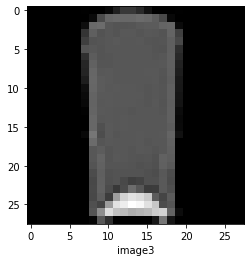

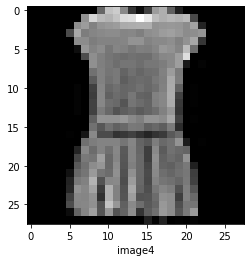

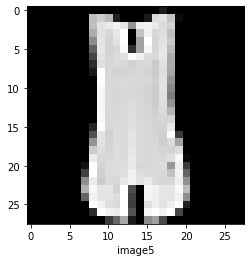

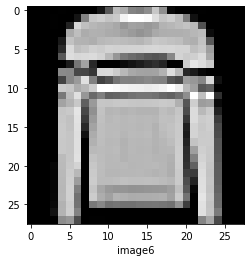

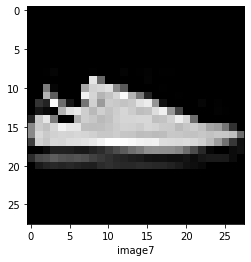

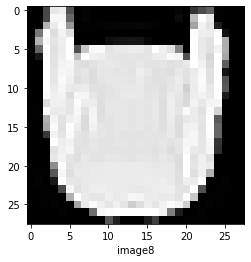

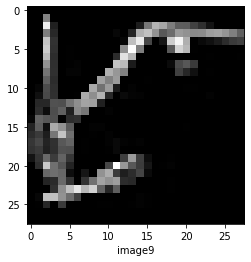

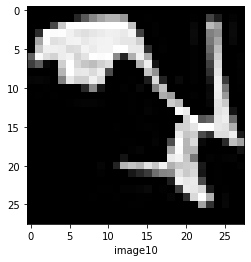

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
nb_images=0;

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1, shuffle=False):
    plt.figure(figsize=(4,4))
    plt.imshow(X_batch.reshape(28,28), cmap=plt.get_cmap("gray"))
    plt.xlabel('image'+str(nb_images+1))
    plt.show()
    nb_images+=1
    if nb_images >= 10: 
      break

L'exemple ci-dessous illustre comment sauvegarder une image. Ici nous sauvons dans le répertoire local donc save_to_dir='.'

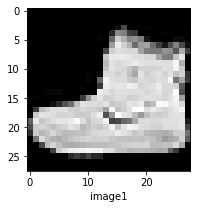

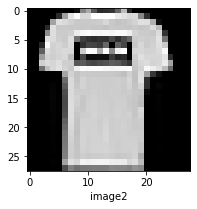

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
nb_images=0;

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1, shuffle=False,
                                     save_to_dir='.', save_prefix='augmente', save_format='png'):
    plt.figure(figsize=(3,3))
    plt.imshow(X_batch.reshape(28,28), cmap=plt.get_cmap("gray"))
    # show the plot
    plt.xlabel('image'+str(nb_images+1))
    plt.show()
    nb_images+=1
    if nb_images >= 2: 
      break

In [ ]:
# pour vérifier que l'image existe dans le répertoire
%ls *.png

augmente_0_6862.png      generated_plot_e030.png
augmente_0_8240.png      generated_plot_e040.png
augmente_0_9965.png      generated_plot_e050.png
augmente_0_9973.png      generated_plot_e060.png
augmente_1_3014.png      generated_plot_e070.png
augmente_1_703.png       generated_plot_e080.png
augmente_1_7195.png      generated_plot_e090.png
augmente_1_937.png       generated_plot_e100.png
generated_plot_e001.png  generated_plot_FashionCNN_withGan001.png
generated_plot_e002.png  generated_plot_FashionCNN_withGan002.png
generated_plot_e010.png  modelCNN.png
generated_plot_e020.png  model.png


Il existe également la méthode *flow_from_directory*. Généralement cette méthode est utilisée pour définir un training set, un validation set et un test set.
Elle considère un répertoire de données (train, validation ou test qui contient déjà les données des différentes classes) - paramètre *directory* et à partir de ces données va générer des données augmentées. Attention il est important de préciser le type de classification que l'on souhaite faire et mettre les bons paramètres. 
Les paramètres suivants sont importants  :  
*labels* : Soit "inferred" (les étiquettes sont générées à partir de la structure du répertoire), None (pas d'étiquettes), ou une liste/tuple d'étiquettes entières de la même taille que le nombre de fichiers image trouvés dans le répertoire. Les étiquettes doivent être triées selon l'ordre alphanumérique des chemins d'accès aux fichiers image (obtenus via os.walk(directory) en Python).
 *label_mode* : - 'int' : signifie que les étiquettes sont codées sous forme d'entiers (par exemple, pour une loss de type sparse_categorical_crossentropy). - 'categorical' signifie que les étiquettes sont encodées sous forme de vecteur categorical (par exemple pour categorical_crossentropy loss). - 'binaire' signifie que les étiquettes (il ne peut y en avoir que 2) sont encodées sous forme de scalaires float32 avec les valeurs 0 ou 1 (par exemple pour binary_crossentropy). - Aucun (pas d'étiquettes).  
*class_names* : valide uniquement si "labels" est "inféré". Il s'agit de la liste explicite des noms de classe (doit correspondre aux noms des sous-répertoires). Utilisé pour contrôler l'ordre des classes (sinon l'ordre alphanumérique est utilisé).

Voir la documentation Keras pour les paramètres.  

Enfin il existe aussi *flow_from_dataframe* qui prend ses données à partir de dataframe. Voir documentation.

  
    #  flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, 
    class_mode='categorical', 
    batch_size=32, shuffle=True, 
    seed=None, save_to_dir=None, 
    save_prefix='', save_format='png', 
    follow_links=False, subset=None, interpolation='nearest')

Comme les données de MNIST ne sont pas stockées sur le disque, nous donnons un exemple d'appel :     


    #  train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
   où data/train est le répertoire dans lequel se situe les données d'entraînement et avec une classification binaire.   

**Attention** cela implique que dans le répertoire train il y ait 2 sous répertoires correspondant aux classes à prédire. Par exemple data/train contient deux répertoires avec 40 images chats et chiens avec chacun un certain nombre d'images pour une classification binaire.       

Bien entendu la génération va avoir des conséquences sur la manière d'apprendre le modèle. Certaines versions de Keras ont défini la méthode  *fit_generator* comme l'illustre la cellule suivante :    


    #  
    datagen = ImageDataGenerator(width_shift_range=0.2,     
    height_shift_range=0.2,
    horizontal_flip=True)
    # prepare iterator
    generated_for_train = datagen.flow(X_train, y_train, 
    batch_size=64)
    steps = int(trainX.shape[0] / 64)
    history = model.fit_generator(generated_for_train, 
    steps_per_epoch=steps, epochs=100,
    validation_data=(X_test, y_test), verbose=0)

Cependant cette dernière est "deprecated" et peut être simplement remplacée par fit qui traite également des données générées.

La cellule suivante illustre un exemple d'utilisation de données générées pour apprendre. Par simplification du code,  nous ne faisons pas de cross-validation. 

In [ ]:
epochs=20
batch_size = 32

# chargement du jeu de données
X_train, y_train, X_test, y_test = load_dataset()
# normalisation des données
X_train, X_test = clean_data(X_train, X_test)

# definition du modèle 
# on utilise le même que précédemment             
model = define_model()
print (model.summary())

# mis en place du générateur avec décalage de 0.2 en largeur, 0.2 en hauteur et
# permutation horizontale
datagen = ImageDataGenerator(width_shift_range=0.2,     
                               height_shift_range=0.2,
                                horizontal_flip=True)
  
# preparation de l'iterateur pour remplir les batchs. 
batches = datagen.flow(X_train, y_train, batch_size=batch_size)

# appel de la fonction fit. Dans les anciennes versions de Keras
# mettre fit_generator
history = model.fit(batches, 
                    #steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test), verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 Maxpooling2D_1 (MaxPooling2  (None, 13, 13, 32)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               540900    
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
________________________________________________

**CO2 !!! Remarque IMPORTANTE** Pour gagner du temps, éviter de relancer l'apprentissage et du CO2 un modèle appris est disponible. Nous l'utilisons juste après. Si vous voulez le lancer il faut enlever les commentaires dans la cellule ci-dessous.

In [ ]:
# appel de la fonction fit. Dans les anciennes versions de Keras
# mettre fit_generator

#history = model.fit(batches, 
#                    #steps_per_epoch=X_train.shape[0] // batch_size,
#                    epochs=epochs,
#                    validation_data=(X_test, y_test), verbose=1)


Télécharger le modèle appris : 

In [ ]:
!wget https://www.lirmm.fr/~poncelet/Ressources/CNN_ImageGenerator_modelFMnist.h5

Chargement du modèle :     

In [ ]:
model = load_model('CNN_ImageGenerator_modelFMnist.h5')

Attention dans la cellule suivante, la dernière commande est en commentaire. Etant donné que l'on charge le modèle, history, n'est plus disponible. Pour voir les courbes loss et accuracy il faut relancer l'entraînement du modèle et enlever le # devant plot_curves_confusion (history,conf,class_names). 

**Rappel :** l'utilisation de telles application nécessite beaucoup de CO2 ... est-ce que c'est indispensable si l'on comprend les concepts principaux ? 

313/313 - 2s - loss: 0.4021 - accuracy: 0.8572 - 2s/epoch - 6ms/step


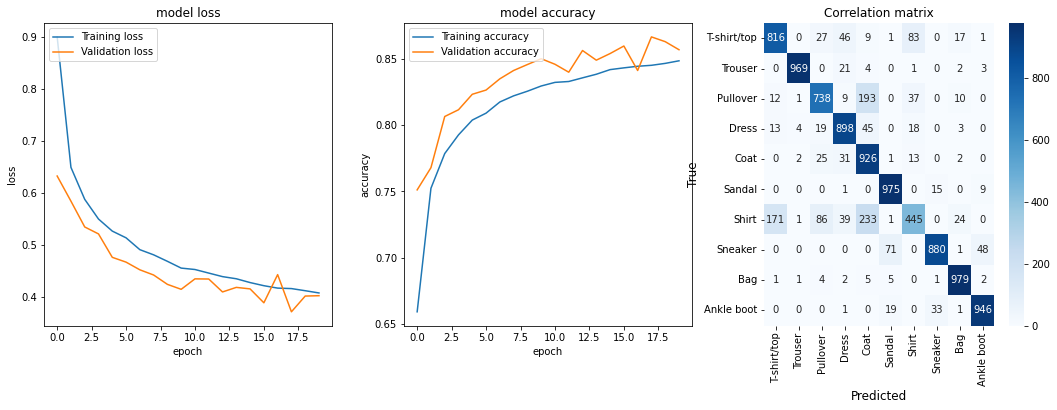

In [ ]:
# class_names pour l'affichage des labels dans la matrice de confusion
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)               
y_pred = model.predict(X_test)
conf=confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print (conf)
#plot_curves_confusion (history,conf,class_names)

###Affichage des feature maps

Dans cette section, nous examinons comment afficher les feature maps afin de voir au sein des différentes couches ce que le modèle retient. Le modèle précédent est un peu petit aussi nous allons utiliser un autre modèle avec un peu plus de couches.   

**CO2 !!! Remarque IMPORTANTE** Pour gagner du temps, éviter de relancer l'apprentissage et du CO2 un modèle appris est disponible. Là aussi nous ne visons pas le meilleur classifieur. Le modèle ci-dessous n'est pas le plus performant.  

    # Modele
    model = Sequential()  
    # Convolution and pooling  
    model.add(Conv2D(filters=32, kernel_size=(3, 3),   
                     activation='relu', 
                     input_shape=(28, 28, 1),   name="Conv2D_1"))  
    model.add(MaxPooling2D(pool_size=(2, 2),   
                           name="Maxpooling2D_1"))  
    
    model.add(Conv2D(64, kernel_size=(3, 3),   
                    activation='relu', name="Conv2D_2"))    
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    
    model.add(Conv2D(128, (3, 3), activation='relu', name="Conv2D_3")) 
    # flatten
    model.add(Flatten(name="flatten") )
    
    # Classification part
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

Téléchargement du modèle et sauvegarde dans le répertoire courant :     

In [ ]:
!wget https://www.lirmm.fr/~poncelet/Ressources/modelCNNFashionMnist.h5

--2022-09-29 21:17:20--  https://www.lirmm.fr/~poncelet/Ressources/modelCNNFashionMnist.h5
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1722768 (1.6M) [text/plain]
Saving to: ‘modelCNNFashionMnist.h5.3’

modelCNNFashionMnis 100%[===================>]   1.64M   444KB/s    in 3.7s    

2022-09-29 21:17:24 (449 KB/s) - ‘modelCNNFashionMnist.h5.3’ saved [1722768/1722768]



Chargement du modèle :     

In [ ]:
model_loaded = load_model('modelCNNFashionMnist.h5')


Nous pouvons examiner les différentes couches du modèle.  

**Remarque** : nous avons explicitement nommé les couches donc nous utilisons le nom donné plutôt que l'indice du layer.

In [ ]:
# Le nombre de couches 
print ("Le modèle a :", len(model_loaded.layers), " couches\n")

# Format des données d'entrée du modèle
print ("Input du modèle : ", model_loaded.input)

# Nom des couches 
layer_names = [layer.name for layer in model_loaded.layers]
print ("\nNom des couches : ", layer_names)

# format des couches 
print ("\nFormat des différentes couches : ")
for i in range(len(model_loaded.layers)):
    layer = model_loaded.layers[i]
    print("format du layer [", i ,"] : ", layer.name , layer.output.shape)	




Le modèle a : 8  couches

Input du modèle :  KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='Conv2D_1_input'), name='Conv2D_1_input', description="created by layer 'Conv2D_1_input'")

Nom des couches :  ['Conv2D_1', 'Maxpooling2D_1', 'Conv2D_2', 'max_pooling2d_3', 'Conv2D_3', 'flatten', 'dense_6', 'dense_7']

Format des différentes couches : 
format du layer [ 0 ] :  Conv2D_1 (None, 26, 26, 32)
format du layer [ 1 ] :  Maxpooling2D_1 (None, 13, 13, 32)
format du layer [ 2 ] :  Conv2D_2 (None, 11, 11, 64)
format du layer [ 3 ] :  max_pooling2d_3 (None, 5, 5, 64)
format du layer [ 4 ] :  Conv2D_3 (None, 3, 3, 128)
format du layer [ 5 ] :  flatten (None, 1152)
format du layer [ 6 ] :  dense_6 (None, 100)
format du layer [ 7 ] :  dense_7 (None, 10)


Il est donc possible de récuperer individuellement les couches de sorties pour les afficher.   

Par exemple ici nous allons extraire les couches correspondant à la sortie de la première convolution. La couche d'entrée correspond à celle du modèle et la couche de sortie à celle de la sortie du layer1. Cela nous permet de définir un modèle sur lequel nous allons pouvoir prédire. La prédiction va permettre de mettre à jour toutes les valeurs.     

In [ ]:
feature_map_layer1 = tf.keras.models.Model(inputs=model_loaded.inputs , outputs=model_loaded.layers[1].output)

Ensuite il suffit de prendre une image et de faire une prédiction de cette image afin d'aller examiner la feature map de la première couche. Comme nous avons une seule image, il faut d'abord étendre les dimensions.  

*Remarque* : ici nous utilisons une image directement de train_images donc elle a déjà été pré-traitée (conversion en float et normalisation).

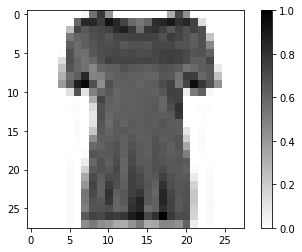

In [ ]:
numimage=10
plt.figure()
plt.imshow(train_images[numimage], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

my_image=train_images[numimage]

# extension des dimensions pour manipuler une seule image
my_image = np.expand_dims(my_image, axis=0)

Il suffit maintenant de prédire la classe de cette image.

In [ ]:
features=feature_map_layer1.predict(my_image)


Nous pouvons afficher le format de sortie du modèle. Il devrait correspondre à l'entrée de la couche suivante (ici Maxpooling2D_1 qui est : (None, 13, 13, 32)

In [ ]:
print (features.shape)

(1, 13, 13, 32)


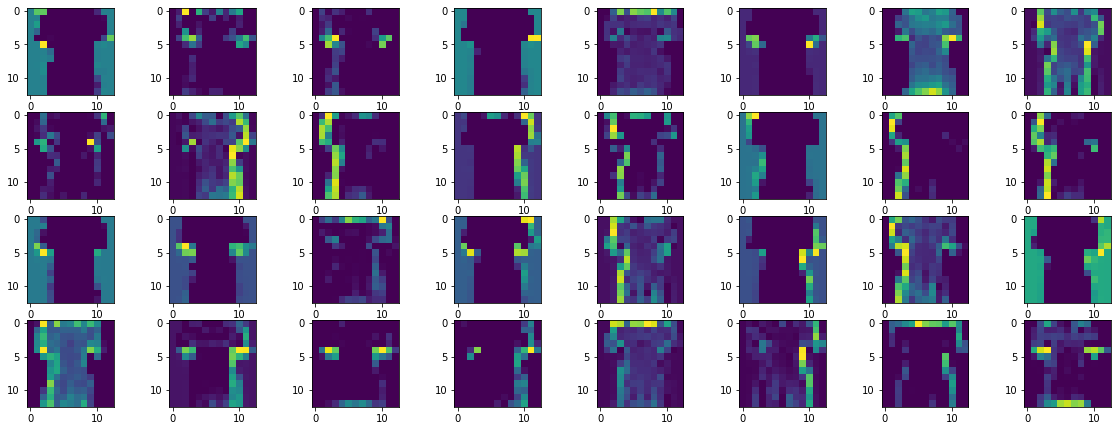

In [ ]:
fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):
    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1])# , cmap='gray')
pyplot.show()

Pour afficher les sorties des couches de convolutions, il suffit de les sélectionner, de récupérer leur sortie et de recréer un modèle pour prédire l'image.

In [ ]:
list_layer_conv=[0,2,4]

# Selection des couches correspondant aux convolutions
outputs = [model_loaded.layers[i].output for i in list_layer_conv]
feature_maps_model = tf.keras.models.Model(inputs=model_loaded.inputs , outputs=outputs)

feature_maps=feature_maps_model.predict(my_image)


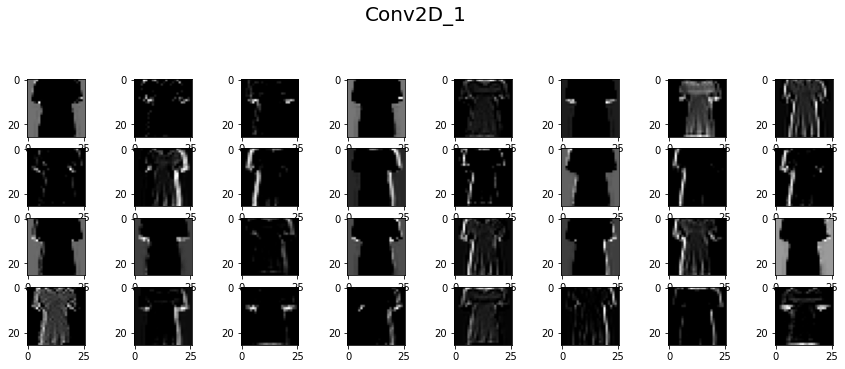

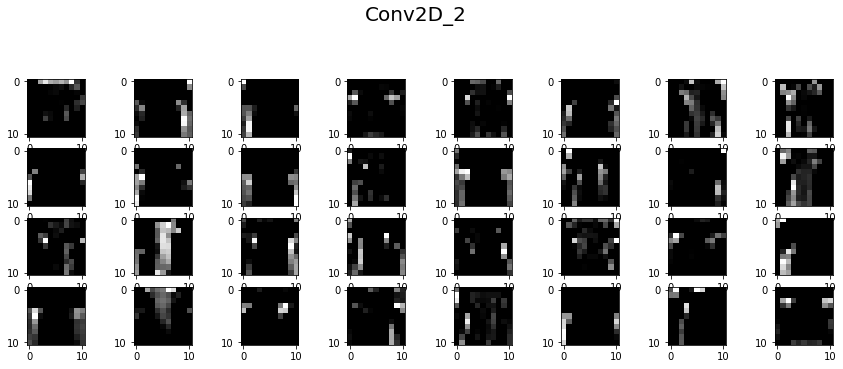

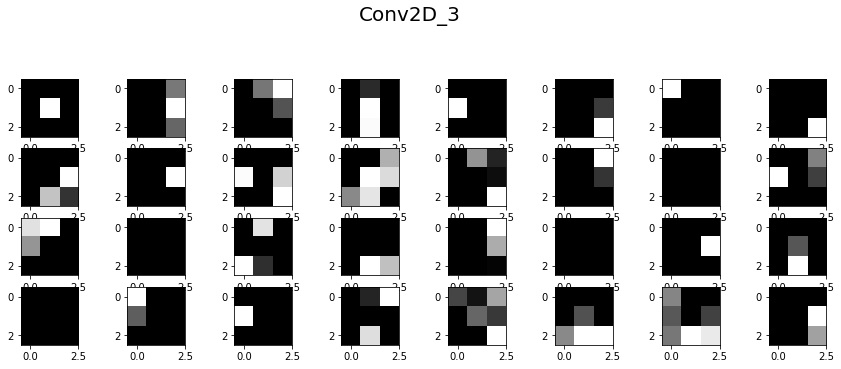

In [ ]:
for i,fmap in zip(list_layer_conv,feature_maps):
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(layer_names[i] , fontsize=20)
    for i in range(1,features.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1] , cmap='gray')
plt.show()

###Transfer Learning

Dans cette section, nous nous intéressons au transfer learning. Le principe est de récupérer un modèle qui a appris et donc mis à jour les valeurs de différents filtres. Il existe de très nombreux modèles disponibles. Pour illustrer, nous allons utiliser le modèle ResNet50 qui est très utilisé. Bien sûr ResNet50 a été appris sur des images couleurs donc ne nous attendons pas à avoir un excellent classifier par rapport à nos images de faible qualité et en noir et blanc. L'objectif de cette section est d'illustrer le fonctionnement du transfer learning.     

L'architecture ResNet a été proposé par Microsoft en 2015 (ResNet : Residual Networks) et a été utilisé de nombreuses fois pour gagner des compétitions. 

Tout d'abord regardons un peu à quoi ressemble ResNet50 : 

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50

model_resnet50=ResNet50()
model_resnet50.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

Nous pouvons constater que ResNet50 est un très gros modèle !! qu'il necessite d'apprendre 25 583 592 paramètres !!!! En fait il possède une profondeur de 50 layers : 48 Convolutions avec chacun une couche de MaxPool et AvaragePool. Ce qui nous intéresse dans ce modèle c'est que tous les poids ont été appris. Par contre si nous regardons les données d'entrée nous voyons qu'il a été appris sur des images de 224x224 avec 3 canaux (RGB).   

**Le principe du transfer Learning** : l'objectif du transfert learning est de profiter que des modèles existent avec des poids mis à jour. Si les modèles ont été appris avec énormément d'images dans ces poids nous pourrons retrouver les motifs associés à une image.     

Bien entendu il faut que l'entrée du modèle soit similaire sur le nombre de canaux. Par contre même si les images que l'on veut classer ne font pas 224x224, il sera possible que le modèle utilise nos images.    

Le modèle ResNet50 est très éfficace, les poids ont été appris, etc. Ce serait dommage de les perdre : aussi le principe est de 'geler' ces poids (en backpropagation), ils ne seront pas mis à jour. Il reste donc juste à récupérer toutes les couches (sauf la dernière utilisée pour la classification) et d'ajouter les MLP chargés de la partie classification.    

Qu'est ce que cela donne avec Fashion Mnist :     

In [13]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print ("X_train et X_test à l'origine : ", X_train.shape, ' ', X_test.shape)


X_train et X_test à l'origine :  (60000, 28, 28)   (10000, 28, 28)


Il faut d'abord convertir les données pour qu'elle soit au bon format (l'entrée du modèle attend une image sur 3 canaux) :      

In [14]:
# convertir X_train et X_test en 2 dimensions
X_train=X_train.reshape(X_train.shape[0], 28, 28)
X_test=X_test.reshape(X_test.shape[0], 28, 28)

print ("X_train et X_test en image 28x28 : ", X_train.shape, ' ', X_test.shape)

X_train=X_train.astype("float32")
X_test=X_test.astype("float32")

# conversion en 3 canaux

X_train=np.stack((X_train,)*3, axis=-1)
X_test=np.stack((X_test,)*3, axis=-1)

print ("X_train et X_test en image 28x28 et 3 canaux : ", X_train.shape, ' ', X_test.shape)

# one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train et X_test en image 28x28 :  (60000, 28, 28)   (10000, 28, 28)
X_train et X_test en image 28x28 et 3 canaux :  (60000, 28, 28, 3)   (10000, 28, 28, 3)


Nous avons vu précédemment comment utiliser ImageDataGenerator. Nous l'utilisons pour créer un jeu d'apprentissage et de validation. 

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest")
train_iterator=datagen.flow(X_train, y_train, batch_size=512, shuffle=True)

val_generator=ImageDataGenerator(rescale=1./255)
val_iterator=val_generator.flow(X_test, y_test, batch_size=512, shuffle=True)

Nous pouvons maintenant créer le modèle. Ce dernier aura comme première couche ce qui est issu de ResNet et nous rajoutons une partie classification.    

Pour charger ResNet50, il suffit de l'ajouter par contre nous éliminons sa dernière couche en mettant include_top à False   :       

    ResNet50 (include_top=False, pooling='avg', weights='imagenet')    

**Remarque** : ici nous spécifions que les poids que nous voulons viennent d'imagenet. En fait il s'agit d'une compétition "Imagenet Large Scale Visual Recognition Challenge (ILSVRC)" où il y a beaucoup de compétitions. Ceci a pour effet de charger les poids associés. Si nous ne spécifions rien, les poids sont aléatoires ... donc sans intérêt pour notre but.        

In [19]:
model=Sequential()
model.add(ResNet50 (include_top=False, pooling='avg', weights='imagenet'))
# ajout d'une partie classification
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

94781440/94765736 [==============================] - 0s 0us/step


Et voilà nous avons défini le modèle :

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 24,588,810
Non-trainable params: 53,120
_________________________________________________________________


Si on regarde l'architecture du modèle nous voyons que nous avons à présent 23587712 paramètres venant de ResNet50 auxquels s'ajoutent ceux de nos deux dernières couches : 1049088 + 5130 !!!       

En fait notre objectif est justement de ne pas toucher aux poids venant de ResNet50. Si on les enlève il restera tout de même 1049088 + 5130 paramètres.    

Pour ne pas toucher au poids de ResNet il faut spécifier que cette partie n'est pas entraînable et donc que lors de la backpropagation les poids ne pourront pas être mis à jour. Notre modèle est composé de trois couches. Il suffit donc de préciser que la première couche ne doit pas être appris :     

In [21]:
model.layers[0].trainable=False

Nous pouvons à présent compiler le modèle et lancer l'apprentissage :     

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


L'entrainement du modèle se fait comme d'habitude :      

**Remarque :** L'entraînement est très long ... car il faut passer ne serait ce que pour le forward par toutes les couches de ResNet et également le générateur d'images. **Penser bien à aller dans l'onglet Modifier/Paramètres du Notebook pour passer en GPU pour l'exécuter**. Si vous l'exécuter, vous verrez qu'au fur et à mesure l'accuracy va augmenter et la loss diminuer : le modèle apprend bien !

**Remarque CO2 :** comme précédemment la ligne suivante est commentée. Vous trouverez en dessous le modèle appris sur 10 epochs.

In [27]:
#model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
118/118 [==============================] - 322s 3s/step - loss: 1.2661 - accuracy: 0.5511 - val_loss: 0.9661 - val_accuracy: 0.6600
Epoch 2/10
118/118 [==============================] - 246s 2s/step - loss: 1.0674 - accuracy: 0.6139 - val_loss: 0.8722 - val_accuracy: 0.6767
Epoch 3/10
118/118 [==============================] - 237s 2s/step - loss: 0.9819 - accuracy: 0.6412 - val_loss: 0.8631 - val_accuracy: 0.6769
Epoch 4/10
118/118 [==============================] - 268s 2s/step - loss: 0.9349 - accuracy: 0.6591 - val_loss: 0.7908 - val_accuracy: 0.7048
Epoch 5/10
118/118 [==============================] - 229s 2s/step - loss: 0.8975 - accuracy: 0.6726 - val_loss: 0.8470 - val_accuracy: 0.6642
Epoch 6/10
118/118 [==============================] - 230s 2s/step - loss: 0.8700 - accuracy: 0.6824 - val_loss: 0.7911 - val_accuracy: 0.6871
Epoch 7/10
118/118 [==============================] - 232s 2s/step - loss: 0.8604 - accuracy: 0.6831 - val_loss: 0.8304 - val_accuracy: 0.6715

Si vous voulez charger le modèle pour prédire :     

In [31]:
model_from_transfert = load_model('final_modelTransferLearningFMnist.h5')